This notebook generates the following panels:
- ( ) Summary - Raster: PSTH average of all depth neurons, sorted by fitted preferred depth

use env 2p_analysis_cottage

In [1]:
VERSION = 1

In [11]:
%reload_ext autoreload
%autoreload 2
import os
import sys
import defopt
import pickle
import numpy as np
import pandas as pd
import scipy.stats
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42 # save text as text not outlines
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import ListedColormap
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings

from cottage_analysis.depth_analysis.filepath import generate_filepaths
from cottage_analysis.stimulus_structure.sphere_structure import *
from cottage_analysis.depth_analysis.depth_preprocess.process_params import create_speed_arr, create_trace_arr_per_roi, calculate_OF, thr
from cottage_analysis.depth_analysis.plotting.plotting_utils import *
from cottage_analysis.depth_analysis.plotting.basic_vis_plots import *

/camp/home/hey2/.conda/envs/2p_analysis_cottage/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
save_root = '/camp/lab/znamenskiyp/home/shared/presentations/Cosyne2023/ver'+str(VERSION)+'/close_raster_summary/'
if not os.path.exists(save_root):
    os.makedirs(save_root)
    
rawdata_root = '/camp/lab/znamenskiyp/data/instruments/raw_data/projects/'
root = '/camp/lab/znamenskiyp/home/shared/projects/'

project='hey2_3d-vision_foodres_20220101'
mouses = ['PZAH6.4b','PZAG3.4f']
V1_sessions = [['S20220512','S20220511','S20220429','S20220419','S20220426','S20220506','S20220503','S20220505','S20220516'],['S20220504','S20220426','S20220421','S20220419','S20220505','S20220503','S20220510','S20220512','S20220511']]
protocol='SpheresPermTubeReward'
playback=False

# COMBINE PSTH FROM ALL DEPTH NEURONS OF ALL SESSIONS INTO A GIANT LIST
all_neurons_psth = []
all_neurons_preferred_depths = []
for k in range(len(V1_sessions)):
    mouse = mouses[k]
    for session in V1_sessions[k]:
        print(mouse, session)
        depth_list = [0.06, 0.19, 0.6, 1.9, 6]
        choose_trials = 50
        frame_rate = 15
        speed_thr_cal = 0.2  # m/s, threshold for running speed when calculating depth neurons
        speed_thr = 0.01  #m/s
        manual_choose_rois = True
        manually_chosen_rois = [1]
        distance_max = 6

        # Generate file path
        original_files = {}
        original_files['rawdata_folder'], \
        original_files['protocol_folder'], \
        original_files['analysis_folder'], \
        original_files['suite2p_folder'], \
        original_files['trace_folder'] = generate_filepaths.generate_file_folders(
            project=project,
            mouse=mouse,
            session=session,
            protocol=protocol,
            rawdata_root=rawdata_root,
            root=root)

        if playback:
            playback_files = {}
            playback_files['rawdata_folder'], \
            playback_files['protocol_folder'], \
            playback_files['analysis_folder'], \
            playback_files['suite2p_folder'], \
            playback_files['trace_folder'] = generate_filepaths.generate_file_folders(
                project=project,
                mouse=mouse,
                session=session,
                protocol=protocol+'Playback',
                rawdata_root=rawdata_root,
                root=root)

        # Load files
        # Load suite2p files
        ops = np.load(original_files['suite2p_folder']/'ops.npy', allow_pickle=True)
        ops = ops.item()
        iscell = np.load(original_files['suite2p_folder']/'iscell.npy', allow_pickle=True)[:, 0]
        F = np.load(original_files['trace_folder']/'F.npy', allow_pickle=True)
        # Fast = np.load(trace_folder + 'Fast.npy', allow_pickle=True)
        # Fneu = np.load(trace_folder + 'Fneu.npy', allow_pickle=True)
        # spks = np.load(trace_folder + 'spks.npy', allow_pickle=True)

        # All_rois
        which_rois = (np.arange(F.shape[0]))[iscell.astype('bool')]

        # dffs_ast
        dffs_original = np.load(original_files['trace_folder']/'dffs_ast.npy')
        if playback:
            dffs_playback = np.load(playback_files['trace_folder']/'dffs_ast.npy')

        # Load stim structure file
        with open(original_files['protocol_folder']/'img_VS.pickle', 'rb') as handle:
            img_VS_original = pickle.load(handle)
        if os.path.exists(original_files['protocol_folder']/'stim_dict.pickle'):
            with open(original_files['protocol_folder']/'stim_dict.pickle', 'rb') as handle:
                stim_dict_original = pickle.load(handle)
        else:
            stim_dict_original = create_stim_dict(depth_list=depth_list, img_VS=img_VS_original, choose_trials=choose_trials)
        with open(original_files['analysis_folder']/'plane0/gaussian_depth_tuning_fit_new_0.5.pickle', 'rb') as handle:
            gaussian_depth_original = pickle.load(handle)

        if playback:
            with open(playback_files['protocol_folder']/'img_VS.pickle', 'rb') as handle:
                img_VS_playback = pickle.load(handle)
            if os.path.exists(playback_files['protocol_folder']/'stim_dict.pickle'):
                with open(playback_files['protocol_folder']/'stim_dict.pickle', 'rb') as handle:
                    stim_dict_playback = pickle.load(handle)
            else:
                stim_dict_playback = create_stim_dict(depth_list=depth_list, img_VS=img_VS_playback, choose_trials=choose_trials)
            with open(playback_files['analysis_folder']/'plane0/gaussian_depth_tuning_fit_new_0.5.pickle', 'rb') as handle:
                gaussian_depth_playback = pickle.load(handle)

        # Load depth neurons
        depth_neurons = np.load(original_files['analysis_folder']/'plane0/depth_neurons.npy')
        max_depths_original = np.load(original_files['analysis_folder']/'plane0/max_depths_index.npy')
        # max_depths_gaussian_fit = np.load(original_files['analysis_folder'] + 'plane0/max_LogDepth_gaussianfit.npy')
        if playback:
            max_depths_playback = np.load(playback_files['analysis_folder']/'plane0/max_depths_index.npy')
            # max_depths_gaussian_fit = np.load(playback_files['analysis_folder'] + 'plane0/max_LogDepth_gaussianfit.npy')

        # PARAMS PROCESSING
        # Speed array
        # Running speed is thresholded with a small threshold to get rid of non-zero values (default threshold 0.01)
        # Closeloop
        speeds_original = img_VS_original.MouseZ.diff() / img_VS_original.HarpTime.diff() # with no playback. EyeZ and MouseZ should be the same.
        speeds_original[0] = 0
        speeds_original = thr(speeds_original, speed_thr)
        speed_arr_original, _ = create_speed_arr(speeds_original, depth_list, stim_dict_original, mode='sort_by_depth', protocol='fix_length',
                                        blank_period=0, frame_rate=frame_rate)
        speed_arr_mean_original = np.nanmean(speed_arr_original,axis=1)
        speed_arr_noblank_original,_ = create_speed_arr(speeds_original, depth_list, stim_dict_original, mode='sort_by_depth', protocol='fix_length', blank_period=0, frame_rate=frame_rate)
        speed_arr_noblank_mean_original = np.nanmean(speed_arr_noblank_original,axis=1)
        speed_arr_blank_original,_ = create_speed_arr(speeds_original, depth_list, stim_dict_original, mode='sort_by_depth', protocol='fix_length', isStim=False, blank_period=0, frame_rate=frame_rate)
        frame_num_pertrial_max_original = speed_arr_noblank_original.shape[2]
        total_trials_original = speed_arr_noblank_original.shape[1]
        optics_original = calculate_OF(rs=speeds_original, img_VS=img_VS_original, mode='no_RF')

        # Array of distance travelled from each trial start (m)
        distance_arr_original, _ = create_speed_arr(img_VS_original['EyeZ'], depth_list, stim_dict_original, mode='sort_by_depth',
                                            protocol='fix_length', blank_period=0, frame_rate=frame_rate)
        for idepth in range(distance_arr_original.shape[0]):
            for itrial in range(distance_arr_original.shape[1]):
                distance_arr_original[idepth, itrial, :] = distance_arr_original[idepth, itrial, :] - distance_arr_original[idepth, itrial, 0]

        # Openloop
        if playback:
            speeds_playback = img_VS_playback.MouseZ.diff() / img_VS_playback.HarpTime.diff() # with no playback. EyeZ and MouseZ should be the same.
            speeds_playback[0] = 0
            speeds_playback = thr(speeds_playback, speed_thr)
            speed_arr_playback, _ = create_speed_arr(speeds_playback, depth_list, stim_dict_playback, mode='sort_by_depth', protocol='fix_length',
                                            blank_period=0, frame_rate=frame_rate)
            speed_arr_mean_playback = np.nanmean(speed_arr_playback,axis=1)
            speed_arr_noblank_playback,_ = create_speed_arr(speeds_playback, depth_list, stim_dict_playback, mode='sort_by_depth', protocol='fix_length', blank_period=0, frame_rate=frame_rate)
            speed_arr_noblank_mean_playback = np.nanmean(speed_arr_noblank_playback,axis=1)
            speed_arr_blank_playback,_ = create_speed_arr(speeds_playback, depth_list, stim_dict_playback, mode='sort_by_depth', protocol='fix_length', isStim=False, blank_period=0, frame_rate=frame_rate)
            frame_num_pertrial_max_playback = speed_arr_noblank_playback.shape[2]
            total_trials_playback = speed_arr_noblank_playback.shape[1]

            speeds_eye_playback = img_VS_playback.EyeZ.diff() / img_VS_playback.HarpTime.diff()  # EyeZ is how the perspective of animal moves
            speeds_eye_playback[0] = 0
            speeds_eye_playback = thr(speeds_eye_playback, speed_thr)
            optics_playback = calculate_OF(rs=speeds_eye_playback, img_VS=img_VS_playback, mode='no_RF')


            # Array of distance travelled from each trial start (m)
            distance_arr_playback, _ = create_speed_arr(img_VS_playback['EyeZ'], depth_list, stim_dict_playback, mode='sort_by_depth',
                                                protocol='fix_length', blank_period=0, frame_rate=frame_rate)
            for idepth in range(distance_arr_playback.shape[0]):
                for itrial in range(distance_arr_playback.shape[1]):
                    distance_arr_playback[idepth, itrial, :] = distance_arr_playback[idepth, itrial, :] - distance_arr_playback[idepth, itrial, 0]



        # Get PSTH for all depth neurons
        for roi in depth_neurons:
            binned_stats = get_PSTH(values = dffs_original, 
            dffs=dffs_original,  
            depth_list=depth_list, 
            stim_dict=stim_dict_original,
            roi=roi,
            distance_arr=distance_arr_original, 
            distance_bins=60,
            is_trace=True)
            PSTH_ave = np.nanmean(binned_stats['binned_yrr'], axis=1).flatten()

            all_neurons_psth.append(PSTH_ave)
        
        all_neurons_preferred_depths.append(np.array(np.exp(gaussian_depth_original.x0_logged.values.astype('float32'))).tolist())
        print('Finish appending for this session.')
print('Finish appending for ALL sessions.')

/camp/home/hey2/.conda/envs/2p_analysis_cottage/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-12-a3d3d0b5a26f>:36: DeprecationWarning: rawdata_root will be read from flexiznam config. Remove parameter
  original_files['trace_folder'] = generate_filepaths.generate_file_folders(
<ipython-input-12-a3d3d0b5a26f>:36: DeprecationWarning: root will be read from flexiznam config. Remove parameter
  original_files['trace_folder'] = generate_filepaths.generate_file_folders(
/nemo/lab/znamenskiyp/home/users/hey2/codes/cottage_analysis/cottage_analysis/depth_analysis/filepath/generate_filepaths.py:129: DeprecationWarning: flexilims_session will become mandatory
  sess_children = get_session_

PZAH6.4b S20220512


/nemo/lab/znamenskiyp/home/users/hey2/codes/cottage_analysis/cottage_analysis/depth_analysis/filepath/generate_filepaths.py:134: DeprecationWarning: flexilims_session will become mandatory
  recording_entries, recording_path = get_recording_entries(
<ipython-input-12-a3d3d0b5a26f>:115: RuntimeWarning: Mean of empty slice
  speed_arr_mean_original = np.nanmean(speed_arr_original,axis=1)
<ipython-input-12-a3d3d0b5a26f>:117: RuntimeWarning: Mean of empty slice
  speed_arr_noblank_mean_original = np.nanmean(speed_arr_noblank_original,axis=1)


Finish appending for this session.
PZAH6.4b S20220511


<ipython-input-12-a3d3d0b5a26f>:36: DeprecationWarning: rawdata_root will be read from flexiznam config. Remove parameter
  original_files['trace_folder'] = generate_filepaths.generate_file_folders(
<ipython-input-12-a3d3d0b5a26f>:36: DeprecationWarning: root will be read from flexiznam config. Remove parameter
  original_files['trace_folder'] = generate_filepaths.generate_file_folders(
/nemo/lab/znamenskiyp/home/users/hey2/codes/cottage_analysis/cottage_analysis/depth_analysis/filepath/generate_filepaths.py:129: DeprecationWarning: flexilims_session will become mandatory
  sess_children = get_session_children(
/nemo/lab/znamenskiyp/home/users/hey2/codes/cottage_analysis/cottage_analysis/depth_analysis/filepath/generate_filepaths.py:134: DeprecationWarning: flexilims_session will become mandatory
  recording_entries, recording_path = get_recording_entries(


Finish appending for this session.
PZAH6.4b S20220429


<ipython-input-12-a3d3d0b5a26f>:36: DeprecationWarning: rawdata_root will be read from flexiznam config. Remove parameter
  original_files['trace_folder'] = generate_filepaths.generate_file_folders(
<ipython-input-12-a3d3d0b5a26f>:36: DeprecationWarning: root will be read from flexiznam config. Remove parameter
  original_files['trace_folder'] = generate_filepaths.generate_file_folders(
/nemo/lab/znamenskiyp/home/users/hey2/codes/cottage_analysis/cottage_analysis/depth_analysis/filepath/generate_filepaths.py:129: DeprecationWarning: flexilims_session will become mandatory
  sess_children = get_session_children(
/nemo/lab/znamenskiyp/home/users/hey2/codes/cottage_analysis/cottage_analysis/depth_analysis/filepath/generate_filepaths.py:134: DeprecationWarning: flexilims_session will become mandatory
  recording_entries, recording_path = get_recording_entries(


Finish appending for this session.
PZAH6.4b S20220419


<ipython-input-12-a3d3d0b5a26f>:36: DeprecationWarning: rawdata_root will be read from flexiznam config. Remove parameter
  original_files['trace_folder'] = generate_filepaths.generate_file_folders(
<ipython-input-12-a3d3d0b5a26f>:36: DeprecationWarning: root will be read from flexiznam config. Remove parameter
  original_files['trace_folder'] = generate_filepaths.generate_file_folders(
/nemo/lab/znamenskiyp/home/users/hey2/codes/cottage_analysis/cottage_analysis/depth_analysis/filepath/generate_filepaths.py:129: DeprecationWarning: flexilims_session will become mandatory
  sess_children = get_session_children(
/nemo/lab/znamenskiyp/home/users/hey2/codes/cottage_analysis/cottage_analysis/depth_analysis/filepath/generate_filepaths.py:134: DeprecationWarning: flexilims_session will become mandatory
  recording_entries, recording_path = get_recording_entries(


Finish appending for this session.
PZAH6.4b S20220426


<ipython-input-12-a3d3d0b5a26f>:36: DeprecationWarning: rawdata_root will be read from flexiznam config. Remove parameter
  original_files['trace_folder'] = generate_filepaths.generate_file_folders(
<ipython-input-12-a3d3d0b5a26f>:36: DeprecationWarning: root will be read from flexiznam config. Remove parameter
  original_files['trace_folder'] = generate_filepaths.generate_file_folders(
/nemo/lab/znamenskiyp/home/users/hey2/codes/cottage_analysis/cottage_analysis/depth_analysis/filepath/generate_filepaths.py:129: DeprecationWarning: flexilims_session will become mandatory
  sess_children = get_session_children(
/nemo/lab/znamenskiyp/home/users/hey2/codes/cottage_analysis/cottage_analysis/depth_analysis/filepath/generate_filepaths.py:134: DeprecationWarning: flexilims_session will become mandatory
  recording_entries, recording_path = get_recording_entries(


Finish appending for this session.
PZAH6.4b S20220506


<ipython-input-12-a3d3d0b5a26f>:36: DeprecationWarning: rawdata_root will be read from flexiznam config. Remove parameter
  original_files['trace_folder'] = generate_filepaths.generate_file_folders(
<ipython-input-12-a3d3d0b5a26f>:36: DeprecationWarning: root will be read from flexiznam config. Remove parameter
  original_files['trace_folder'] = generate_filepaths.generate_file_folders(
/nemo/lab/znamenskiyp/home/users/hey2/codes/cottage_analysis/cottage_analysis/depth_analysis/filepath/generate_filepaths.py:129: DeprecationWarning: flexilims_session will become mandatory
  sess_children = get_session_children(
/nemo/lab/znamenskiyp/home/users/hey2/codes/cottage_analysis/cottage_analysis/depth_analysis/filepath/generate_filepaths.py:134: DeprecationWarning: flexilims_session will become mandatory
  recording_entries, recording_path = get_recording_entries(


Finish appending for this session.
PZAH6.4b S20220503


<ipython-input-12-a3d3d0b5a26f>:36: DeprecationWarning: rawdata_root will be read from flexiznam config. Remove parameter
  original_files['trace_folder'] = generate_filepaths.generate_file_folders(
<ipython-input-12-a3d3d0b5a26f>:36: DeprecationWarning: root will be read from flexiznam config. Remove parameter
  original_files['trace_folder'] = generate_filepaths.generate_file_folders(
/nemo/lab/znamenskiyp/home/users/hey2/codes/cottage_analysis/cottage_analysis/depth_analysis/filepath/generate_filepaths.py:129: DeprecationWarning: flexilims_session will become mandatory
  sess_children = get_session_children(
/nemo/lab/znamenskiyp/home/users/hey2/codes/cottage_analysis/cottage_analysis/depth_analysis/filepath/generate_filepaths.py:134: DeprecationWarning: flexilims_session will become mandatory
  recording_entries, recording_path = get_recording_entries(


Finish appending for this session.
PZAH6.4b S20220505


<ipython-input-12-a3d3d0b5a26f>:36: DeprecationWarning: rawdata_root will be read from flexiznam config. Remove parameter
  original_files['trace_folder'] = generate_filepaths.generate_file_folders(
<ipython-input-12-a3d3d0b5a26f>:36: DeprecationWarning: root will be read from flexiznam config. Remove parameter
  original_files['trace_folder'] = generate_filepaths.generate_file_folders(
/nemo/lab/znamenskiyp/home/users/hey2/codes/cottage_analysis/cottage_analysis/depth_analysis/filepath/generate_filepaths.py:129: DeprecationWarning: flexilims_session will become mandatory
  sess_children = get_session_children(
/nemo/lab/znamenskiyp/home/users/hey2/codes/cottage_analysis/cottage_analysis/depth_analysis/filepath/generate_filepaths.py:134: DeprecationWarning: flexilims_session will become mandatory
  recording_entries, recording_path = get_recording_entries(


Finish appending for this session.
PZAH6.4b S20220516


<ipython-input-12-a3d3d0b5a26f>:36: DeprecationWarning: rawdata_root will be read from flexiznam config. Remove parameter
  original_files['trace_folder'] = generate_filepaths.generate_file_folders(
<ipython-input-12-a3d3d0b5a26f>:36: DeprecationWarning: root will be read from flexiznam config. Remove parameter
  original_files['trace_folder'] = generate_filepaths.generate_file_folders(
/nemo/lab/znamenskiyp/home/users/hey2/codes/cottage_analysis/cottage_analysis/depth_analysis/filepath/generate_filepaths.py:129: DeprecationWarning: flexilims_session will become mandatory
  sess_children = get_session_children(
/nemo/lab/znamenskiyp/home/users/hey2/codes/cottage_analysis/cottage_analysis/depth_analysis/filepath/generate_filepaths.py:134: DeprecationWarning: flexilims_session will become mandatory
  recording_entries, recording_path = get_recording_entries(


Finish appending for this session.
PZAG3.4f S20220504


<ipython-input-12-a3d3d0b5a26f>:36: DeprecationWarning: rawdata_root will be read from flexiznam config. Remove parameter
  original_files['trace_folder'] = generate_filepaths.generate_file_folders(
<ipython-input-12-a3d3d0b5a26f>:36: DeprecationWarning: root will be read from flexiznam config. Remove parameter
  original_files['trace_folder'] = generate_filepaths.generate_file_folders(
/nemo/lab/znamenskiyp/home/users/hey2/codes/cottage_analysis/cottage_analysis/depth_analysis/filepath/generate_filepaths.py:129: DeprecationWarning: flexilims_session will become mandatory
  sess_children = get_session_children(
/nemo/lab/znamenskiyp/home/users/hey2/codes/cottage_analysis/cottage_analysis/depth_analysis/filepath/generate_filepaths.py:134: DeprecationWarning: flexilims_session will become mandatory
  recording_entries, recording_path = get_recording_entries(


Finish appending for this session.
PZAG3.4f S20220426


<ipython-input-12-a3d3d0b5a26f>:36: DeprecationWarning: rawdata_root will be read from flexiznam config. Remove parameter
  original_files['trace_folder'] = generate_filepaths.generate_file_folders(
<ipython-input-12-a3d3d0b5a26f>:36: DeprecationWarning: root will be read from flexiznam config. Remove parameter
  original_files['trace_folder'] = generate_filepaths.generate_file_folders(
/nemo/lab/znamenskiyp/home/users/hey2/codes/cottage_analysis/cottage_analysis/depth_analysis/filepath/generate_filepaths.py:129: DeprecationWarning: flexilims_session will become mandatory
  sess_children = get_session_children(
/nemo/lab/znamenskiyp/home/users/hey2/codes/cottage_analysis/cottage_analysis/depth_analysis/filepath/generate_filepaths.py:134: DeprecationWarning: flexilims_session will become mandatory
  recording_entries, recording_path = get_recording_entries(


Finish appending for this session.
PZAG3.4f S20220421


<ipython-input-12-a3d3d0b5a26f>:36: DeprecationWarning: rawdata_root will be read from flexiznam config. Remove parameter
  original_files['trace_folder'] = generate_filepaths.generate_file_folders(
<ipython-input-12-a3d3d0b5a26f>:36: DeprecationWarning: root will be read from flexiznam config. Remove parameter
  original_files['trace_folder'] = generate_filepaths.generate_file_folders(
/nemo/lab/znamenskiyp/home/users/hey2/codes/cottage_analysis/cottage_analysis/depth_analysis/filepath/generate_filepaths.py:129: DeprecationWarning: flexilims_session will become mandatory
  sess_children = get_session_children(
/nemo/lab/znamenskiyp/home/users/hey2/codes/cottage_analysis/cottage_analysis/depth_analysis/filepath/generate_filepaths.py:134: DeprecationWarning: flexilims_session will become mandatory
  recording_entries, recording_path = get_recording_entries(


Finish appending for this session.
PZAG3.4f S20220419


<ipython-input-12-a3d3d0b5a26f>:36: DeprecationWarning: rawdata_root will be read from flexiznam config. Remove parameter
  original_files['trace_folder'] = generate_filepaths.generate_file_folders(
<ipython-input-12-a3d3d0b5a26f>:36: DeprecationWarning: root will be read from flexiznam config. Remove parameter
  original_files['trace_folder'] = generate_filepaths.generate_file_folders(
/nemo/lab/znamenskiyp/home/users/hey2/codes/cottage_analysis/cottage_analysis/depth_analysis/filepath/generate_filepaths.py:129: DeprecationWarning: flexilims_session will become mandatory
  sess_children = get_session_children(
/nemo/lab/znamenskiyp/home/users/hey2/codes/cottage_analysis/cottage_analysis/depth_analysis/filepath/generate_filepaths.py:134: DeprecationWarning: flexilims_session will become mandatory
  recording_entries, recording_path = get_recording_entries(


Finish appending for this session.
PZAG3.4f S20220505


<ipython-input-12-a3d3d0b5a26f>:36: DeprecationWarning: rawdata_root will be read from flexiznam config. Remove parameter
  original_files['trace_folder'] = generate_filepaths.generate_file_folders(
<ipython-input-12-a3d3d0b5a26f>:36: DeprecationWarning: root will be read from flexiznam config. Remove parameter
  original_files['trace_folder'] = generate_filepaths.generate_file_folders(
/nemo/lab/znamenskiyp/home/users/hey2/codes/cottage_analysis/cottage_analysis/depth_analysis/filepath/generate_filepaths.py:129: DeprecationWarning: flexilims_session will become mandatory
  sess_children = get_session_children(
/nemo/lab/znamenskiyp/home/users/hey2/codes/cottage_analysis/cottage_analysis/depth_analysis/filepath/generate_filepaths.py:134: DeprecationWarning: flexilims_session will become mandatory
  recording_entries, recording_path = get_recording_entries(


Finish appending for this session.
PZAG3.4f S20220503


<ipython-input-12-a3d3d0b5a26f>:36: DeprecationWarning: rawdata_root will be read from flexiznam config. Remove parameter
  original_files['trace_folder'] = generate_filepaths.generate_file_folders(
<ipython-input-12-a3d3d0b5a26f>:36: DeprecationWarning: root will be read from flexiznam config. Remove parameter
  original_files['trace_folder'] = generate_filepaths.generate_file_folders(
/nemo/lab/znamenskiyp/home/users/hey2/codes/cottage_analysis/cottage_analysis/depth_analysis/filepath/generate_filepaths.py:129: DeprecationWarning: flexilims_session will become mandatory
  sess_children = get_session_children(
/nemo/lab/znamenskiyp/home/users/hey2/codes/cottage_analysis/cottage_analysis/depth_analysis/filepath/generate_filepaths.py:134: DeprecationWarning: flexilims_session will become mandatory
  recording_entries, recording_path = get_recording_entries(


Finish appending for this session.
PZAG3.4f S20220510


<ipython-input-12-a3d3d0b5a26f>:36: DeprecationWarning: rawdata_root will be read from flexiznam config. Remove parameter
  original_files['trace_folder'] = generate_filepaths.generate_file_folders(
<ipython-input-12-a3d3d0b5a26f>:36: DeprecationWarning: root will be read from flexiznam config. Remove parameter
  original_files['trace_folder'] = generate_filepaths.generate_file_folders(
/nemo/lab/znamenskiyp/home/users/hey2/codes/cottage_analysis/cottage_analysis/depth_analysis/filepath/generate_filepaths.py:129: DeprecationWarning: flexilims_session will become mandatory
  sess_children = get_session_children(
/nemo/lab/znamenskiyp/home/users/hey2/codes/cottage_analysis/cottage_analysis/depth_analysis/filepath/generate_filepaths.py:134: DeprecationWarning: flexilims_session will become mandatory
  recording_entries, recording_path = get_recording_entries(


Finish appending for this session.
PZAG3.4f S20220512


<ipython-input-12-a3d3d0b5a26f>:36: DeprecationWarning: rawdata_root will be read from flexiznam config. Remove parameter
  original_files['trace_folder'] = generate_filepaths.generate_file_folders(
<ipython-input-12-a3d3d0b5a26f>:36: DeprecationWarning: root will be read from flexiznam config. Remove parameter
  original_files['trace_folder'] = generate_filepaths.generate_file_folders(
/nemo/lab/znamenskiyp/home/users/hey2/codes/cottage_analysis/cottage_analysis/depth_analysis/filepath/generate_filepaths.py:129: DeprecationWarning: flexilims_session will become mandatory
  sess_children = get_session_children(
/nemo/lab/znamenskiyp/home/users/hey2/codes/cottage_analysis/cottage_analysis/depth_analysis/filepath/generate_filepaths.py:134: DeprecationWarning: flexilims_session will become mandatory
  recording_entries, recording_path = get_recording_entries(


Finish appending for this session.
PZAG3.4f S20220511


<ipython-input-12-a3d3d0b5a26f>:36: DeprecationWarning: rawdata_root will be read from flexiznam config. Remove parameter
  original_files['trace_folder'] = generate_filepaths.generate_file_folders(
<ipython-input-12-a3d3d0b5a26f>:36: DeprecationWarning: root will be read from flexiznam config. Remove parameter
  original_files['trace_folder'] = generate_filepaths.generate_file_folders(
/nemo/lab/znamenskiyp/home/users/hey2/codes/cottage_analysis/cottage_analysis/depth_analysis/filepath/generate_filepaths.py:129: DeprecationWarning: flexilims_session will become mandatory
  sess_children = get_session_children(
/nemo/lab/znamenskiyp/home/users/hey2/codes/cottage_analysis/cottage_analysis/depth_analysis/filepath/generate_filepaths.py:134: DeprecationWarning: flexilims_session will become mandatory
  recording_entries, recording_path = get_recording_entries(


Finish appending for this session.


In [13]:
all_neurons_psth = np.array(all_neurons_psth)
all_neurons_preferred_depths = np.array([j for i in all_neurons_preferred_depths for j in i])
np.save(save_root+'all_neurons_psth.npy',all_neurons_psth)
np.save(save_root+'all_neurons_preferred_depths.npy',all_neurons_preferred_depths)

/camp/home/hey2/.conda/envs/2p_analysis_cottage/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/camp/home/hey2/.conda/envs/2p_analysis_cottage/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


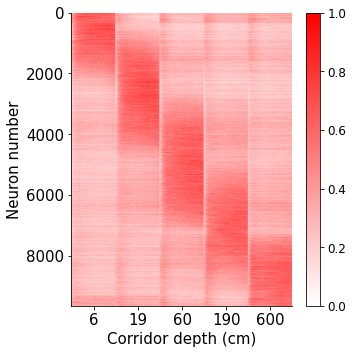

In [34]:
# -- FIG 1: Raster plot of all neurons -- 
save_root = '/camp/lab/znamenskiyp/home/shared/presentations/Cosyne2023/ver'+str(VERSION)+'/close_raster_summary/'
all_neurons_psth = np.load(save_root+'all_neurons_psth.npy')
all_neurons_preferred_depths = np.load(save_root+'all_neurons_preferred_depths.npy')

# Colormap
N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(1, 1, N)
vals[:, 1] = np.linspace(1, 0, N)
vals[:, 2] = np.linspace(1, 0, N)
WhRdcmap = ListedColormap(vals)

# Sort all neurons based on their preferred depth
inds = all_neurons_preferred_depths.argsort()
sortedPSTH = all_neurons_psth[inds,:]

# Normalize each neuron 
sortedPSTH_normed = (sortedPSTH - ((np.nanmin(sortedPSTH, axis=1)).reshape(-1,1))) \
    /((np.nanmax(sortedPSTH, axis=1)).reshape(-1,1)-(np.nanmin(sortedPSTH, axis=1)).reshape(-1,1))
sortedPSTH_normed = np.delete(sortedPSTH_normed, [4514, 7519], axis=0) # delete two cells that have negative response, get rid of these two cells from depth neurons

plt.figure(figsize=(5,5))
plt.imshow(sortedPSTH_normed, aspect='auto', cmap=WhRdcmap)
plt.xticks(np.arange(sortedPSTH.shape[1])[30::60],(np.array(depth_list)*100).astype('int'), fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Neuron number', fontsize=15)
plt.xlabel('Corridor depth (cm)', fontsize=15)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=12)
despine()
plt.tight_layout(pad=1)
plt.savefig(save_root+'all_depth_neurons_raster.pdf')